 **Understanding the dataset**

In [1]:
# Importing necesary libraries
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Reading the train and test datasets
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
# Displaying the first few rows of the training dataset
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


0    4342
1    3271
Name: target, dtype: int64


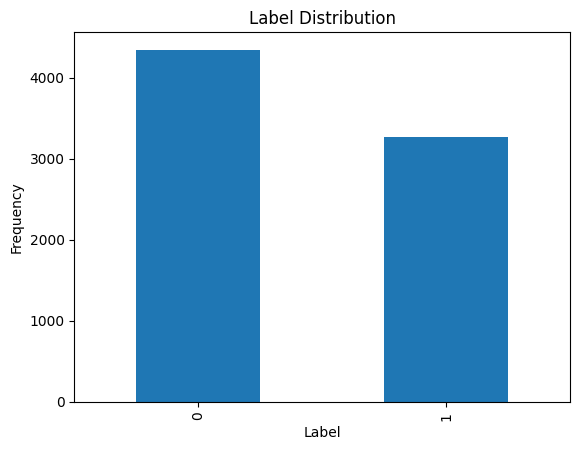

In [4]:
# Getting the distribution of labels in the 'target' column
label_distribution = df_train['target'].value_counts()
print(label_distribution)

# Plotting the label distribution
label_distribution.plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()


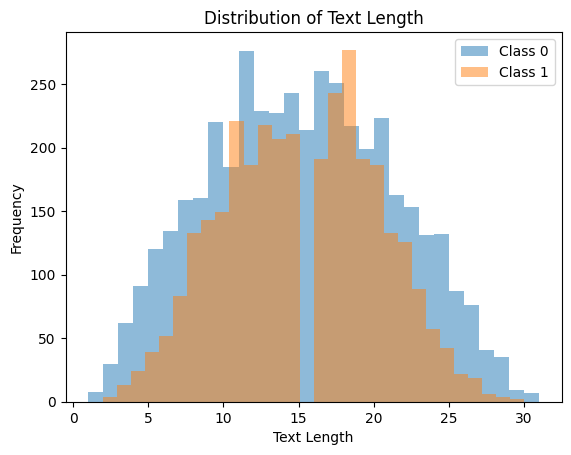

In [5]:
# Plotting the distribution of text lengths for each class
df_train['text_length'] = df_train['text'].apply(lambda x: len(str(x).split()))
plt.figure()
plt.hist(df_train[df_train['target']==0]['text_length'], bins=30, alpha=0.5, label='Class 0')
plt.hist(df_train[df_train['target']==1]['text_length'], bins=30, alpha=0.5, label='Class 1')
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


In [6]:
# Checking and printing the number of missing values in the 'text' column
missing_values = df_train['text'].isnull().sum()
print(f"Missing values in 'text' column: {missing_values}")

# Checking for the presence of special characters in the 'text' column
special_chars = df_train['text'].apply(lambda x: any(char in '#@&*%!?' for char in str(x)))
special_chars_count = special_chars.sum()
print(f"Number of texts with special characters: {special_chars_count}")


Missing values in 'text' column: 0
Number of texts with special characters: 4367


**Data Preprocessing**

In [7]:
# Import the regular expression module
import re

In [8]:
# Convert all text to lowercase
df_train['text'] = df_train['text'].str.lower()
df_test['text'] = df_test['text'].str.lower()

# Function to remove hashtags
def remove_hashtags(text):
    return re.sub(r'#\S+', '', text)

df_train['text'] = df_train['text'].apply(lambda x: remove_hashtags(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_hashtags(x))

# Function to remove URLs
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

df_train['text'] = df_train['text'].apply(lambda x: remove_urls(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_urls(x))

# Function to remove HTLM tags
def remove_html(text):
    return re.sub(r'<.*?>', '', text)

df_train['text'] = df_train['text'].apply(lambda x: remove_html(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_html(x))

# Function to remove special characters
def remove_special_chars(text):
    return re.sub(r'[^a-zA-z0-9\s]', '', text)

df_train['text'] = df_train['text'].apply(lambda x: remove_special_chars(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_special_chars(x))


In [9]:
# Import necessary functionalities from nltk library
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk


In [10]:
# Download necessary datasets from nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
# Initialize the stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Function to preprocess text by tokenizing, removing stopwords, and stemming
def preprocess_text(text):
    words = word_tokenize(text)
    words = [stemmer.stem(word) for word in words if word not in stop_words]

    return ' '.join(words)

df_train['preprocessed_text'] = df_train['text'].apply(preprocess_text)
df_test['preprocessed_text'] = df_test['text'].apply(preprocess_text)


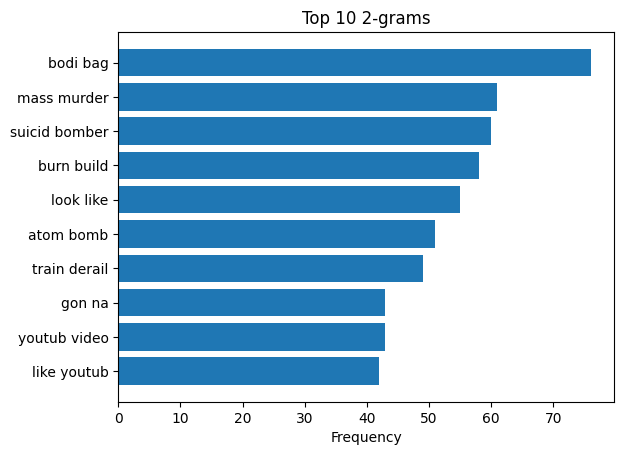

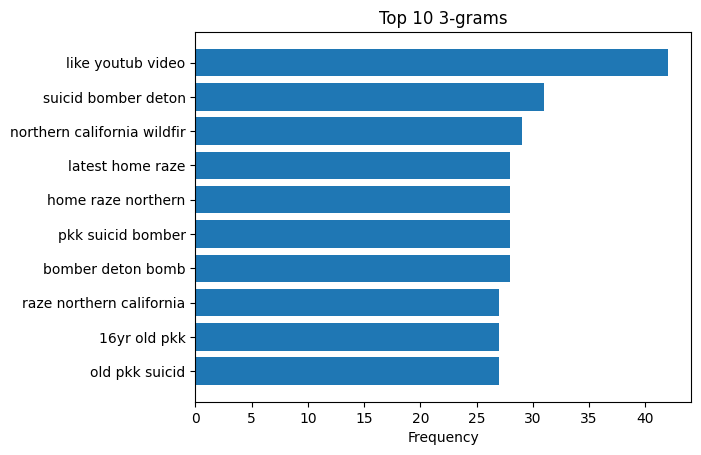

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to plot top n-grams in the text

def plot_top_ngrams(text, n=2, top=10):
    vec = CountVectorizer(ngram_range=(n, n)).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    words_freq = words_freq[:top]
    words, freq = zip(*words_freq)
    plt.barh(words, freq)
    plt.xlabel('Frequency')
    plt.title(f'Top {top} {n}-grams')
    plt.gca().invert_yaxis()
    plt.show()

# Plot top 10 bi-grams abd tri-grams
plot_top_ngrams(df_train['preprocessed_text'], n=2, top=10)
plot_top_ngrams(df_train['preprocessed_text'], n=3, top=10)


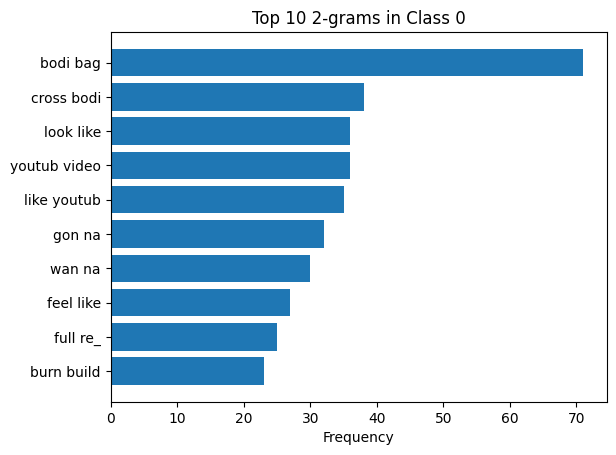

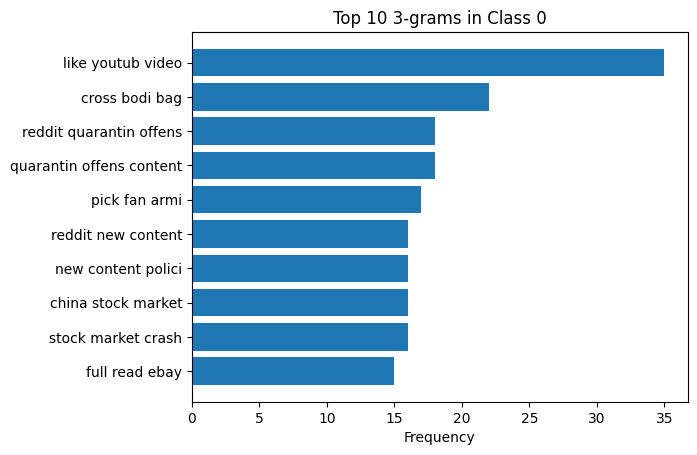

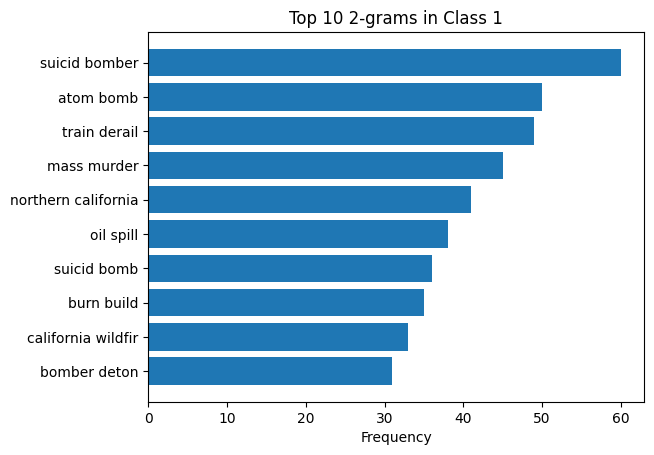

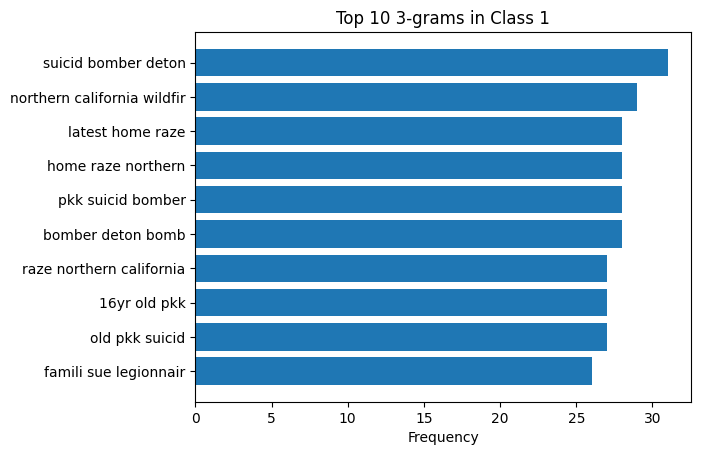

In [14]:
# Define the function to plot top n-grams for disaster and non-disaster tweets
def plot_top_ngrams(text, n=2, top=10, class_label='All'):
    vec = CountVectorizer(ngram_range=(n, n)).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    words_freq = words_freq[:top]
    words, freq = zip(*words_freq)
    plt.barh(words, freq)
    plt.xlabel('Frequency')
    plt.title(f'Top {top} {n}-grams in Class {class_label}')
    plt.gca().invert_yaxis()
    plt.show()
# Subset the data frame by class 0 and class 1
class_0_text = df_train[df_train['target']==0]['preprocessed_text']
class_1_text = df_train[df_train['target']==1]['preprocessed_text']

# Plot top 10 bi-grams and tri-grams for class 0
plot_top_ngrams(class_0_text, n=2, top=10, class_label='0')
plot_top_ngrams(class_0_text, n=3, top=10, class_label='0')

# Plot top 10 bi-grams and tri-grams for class 1
plot_top_ngrams(class_1_text, n=2, top=10, class_label='1')
plot_top_ngrams(class_1_text, n=3, top=10, class_label='1')


In [15]:
df_test.head()

,id,keyword,location,text,preprocessed_text
0,0,NaN,NaN,just happened a terrible car crash,happen terribl car crash
1,2,NaN,NaN,heard about is different cities stay safe eve...,heard differ citi stay safe everyon
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...,forest fire spot pond gees flee across street ...
3,9,NaN,NaN,apocalypse lighting,apocalyps light
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan,typhoon soudelor kill 28 china taiwan


# Baseline

Logistic Regression

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd


In [18]:
X_train, y_train = df_train['text'], df_train['target']

# Create a pipeline with a TF-IDF vectorizer and a logistic regression classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

# Set up the parameter grid
param_grid = {
    'tfidf__max_df': [0.90, 0.95, 1.0],
    'tfidf__min_df': [0.0001, 0.001, 0.01],
    'clf__C': [0.1, 1.0, 10.0],
    'clf__solver': ['lbfgs', 'liblinear']
}


# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=3, verbose=1, n_jobs=-1)

# Train the model
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Get the test data
X_test = df_test['text']

# Predict the labels for the test set using the best model
y_pred_test = best_model.predict(X_test)

# Create a submission file
submission = pd.DataFrame({'id': df_test['id'], 'target': y_pred_test})

# Save the submission file
submission.to_csv('submission_Logistic_Regression.csv', index=False)


Fitting 3 folds for each of 54 candidates, totalling 162 fits


# Using BERT

In [19]:
!pip install transformers
!pip install accelerate -U
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import pandas as pd
import torch.nn as nn

In [20]:
# Define a custom class from BertForSequenceClassification to modify the classifier layer
class CustomBertForSequenceClassification(BertForSequenceClassification):
    def __init__(self, config):
        super(CustomBertForSequenceClassification, self).__init__(config)
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, config.num_labels)
        )

In [21]:
# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased')


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# Function to tokenize the data samples
def tokenize_function(examples):
    return tokenizer([example['text'] for example in examples], padding='max_length', truncation=True, max_length=128)

# Custom dataset class to handle encoding and batching of data samples
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Split the data into training and validation sets
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=42)

# Preprocess the data and tokenize it
train_encodings = tokenize_function(df_train.to_dict('records'))
val_encodings = tokenize_function(df_val.to_dict('records'))
test_encodings = tokenize_function(df_test.to_dict('records')) # use df_test here

# Get labels
train_labels = df_train['target'].tolist()
val_labels = df_val['target'].tolist()

# Create datasets
train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings)

# Function to compute metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=1)
    return {'accuracy': accuracy_score(labels, predictions)}

# Setting-up the training arguments
training_args = TrainingArguments(
    learning_rate=1e-6,
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    weight_decay=0.02,
    logging_dir='./logs',
    logging_steps=10,  # Adjust this value based on your dataset size and batch size
    evaluation_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=2,
    load_best_model_at_end=True,
)

# Initialize the Trainer class with the custom model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()


# Save the best model
trainer.save_model("./best_model")

# Load the best model
best_model = CustomBertForSequenceClassification.from_pretrained("./best_model")

# Make predictions on the test set using the best model
trainer = Trainer(
    model=best_model,
)
predictions = trainer.predict(test_dataset).predictions
predictions = torch.argmax(torch.from_numpy(predictions), dim=1)

#  Create the submission file
submission_df = pd.DataFrame({'id': df_test['id'], 'target': predictions})
submission_df.to_csv('submission.csv', index=False)



Epoch,Training Loss,Validation Loss,Accuracy
1,0.614000,0.622929,0.700787
2,0.546400,0.534611,0.772966
3,0.472300,0.497744,0.791339
4,0.468800,0.479063,0.797900
5,0.465600,0.471808,0.800525
6,0.427100,0.462484,0.807087
7,0.488500,0.458481,0.813648
8,0.440600,0.453827,0.816273
9,0.440200,0.452670,0.816273
10,0.423300,0.452020,0.814961
